Requires [tesseract](https://github.com/tesseract-ocr/tessdoc#binaries) to be installed.

In [1]:
#!pip install numpy matplotlib opencv-python pillow pytesseract

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import pytesseract

In [26]:
def load_image(path_to_image):
    img = cv2.imread(path_to_image, cv2.IMREAD_GRAYSCALE)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    assert img is not None, f'Error opening image {path_to_image}'
    return img

def find_biggest_contour(image, threshold1=20, threshold2=100):
    dst = cv2.Canny(image, threshold1, threshold2, None, 3)
    contours, hierarchy= cv2.findContours(dst, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    return sorted_contours[0]  # largest item

def sort_corners(pts):
    """
    Sorts corners in order top left, top right, bottom left, bottom right
    """
    x_sorted = pts[np.argsort(pts[:, 0, 0]), :]
    leftMost = x_sorted[:2, :]
    rightMost = x_sorted[2:, :]
    tl, bl = leftMost[np.argsort(leftMost[:, 0, 1]), :]
    tr, br = rightMost[np.argsort(rightMost[:, 0, 1]), :]
        
    return np.stack([tl, tr, bl, br])

def perspective_transform(img, to_pts, from_pts=None):
    width = len(img[0])
    height = len(img)
    
    if from_pts is None:
        from_pts = np.array([[0, 0], [width, 0], [0, height], [width, height]], np.float32)
        
    matrix = cv2.getPerspectiveTransform(to_pts, from_pts)
    warped = cv2.warpPerspective(img, matrix, (width, height))
    return warped

def get_corners_of_contour(contour):
    # Find smallest rectangle which includes the contour
    rect = cv2.minAreaRect(contour)
    box = np.int0(cv2.boxPoints(rect))
    
    # Find corners using the euclidean distance
    corners = []
    for reference_point in box:
        corner = []
        corner_distance = sys.maxsize
        for point in largest_item:
            distance = np.linalg.norm(reference_point - point[0])
            if distance < corner_distance:
                corner = point
                corner_distance = distance
        corners.append(corner)
    corners = np.array(corners)
    corners = sort_corners(corners)
    return corners

def detect_lines(image, threshold1=20, threshold2=100):
    dst = cv2.Canny(image, threshold1, threshold2, None, 3)
    lines = cv2.HoughLines(dst, 1, np.pi / 180, 150, None, 0, 0)
    return lines

def merge_lines(lines, rho_threshold=10, theta_threshold=0.2):
    new_lines = []
    lines = lines.tolist()
    while len(lines) > 0:
        rho = lines[0][0][0]
        theta = lines[0][0][1]
        
        tmp_lines = [lines[0]]
        for j in range(1, len(lines)):
            rho_j = lines[j][0][0]
            theta_j = lines[j][0][1]
            if rho_j < rho + rho_threshold and rho_j > rho - rho_threshold \
                and theta_j < theta + theta_threshold and theta_j > theta - theta_threshold:
                tmp_lines.append(lines[j])
                
        avg_rho = sum([line[0][0] for line in tmp_lines]) / len(tmp_lines)
        avg_theta = sum([line[0][1] for line in tmp_lines]) / len(tmp_lines)
        new_lines.append([[avg_rho, avg_theta]])
        
        for line in tmp_lines:
            lines.remove(line)
    return np.array(new_lines)

def get_row_and_col_indexes(lines):
    rows = []
    cols = []
    threshold1 = math.radians(45)
    threshold2 = math.radians(135)
    threshold3 = math.radians(225)
    threshold4 = math.radians(315)
    for line in lines:
        if line[0][1] > threshold4:
            cols.append(line[0][0])
        elif line[0][1] > threshold3:
            rows.append(-line)
        elif line[0][1] > threshold2:
            cols.append(-line[0][0])
        elif line[0][1] > threshold1:
            rows.append(line[0][0])
        else:
            cols.append(line[0][0])

    # Combine to one np.array
    cols = np.stack(cols, axis=0)
    rows = np.stack(rows, axis=0)

    # Sort ascending
    cols = np.sort(cols)
    rows = np.sort(rows)
    
    return rows, cols

def split_image_into_tiles(lines, min_tile_size=20, padding=3):
    rows, cols = get_row_and_col_indexes(lines)
    tiles = []
    last_row = int(rows[0])
    for i in range(1, len(rows)):
        start_row, end_row = last_row, int(rows[i])
        if end_row - start_row < min_tile_size:  # Skip if too small
            continue

        last_col = int(cols[0])
        for j in range(1, len(cols)):
            start_col, end_col = last_col, int(cols[j])
            if end_col - start_col < min_tile_size:
                continue

            tile = {
                'row_start': start_row + padding,
                'row_end': end_row - padding,
                'col_start': start_col + padding,
                'col_end': end_col - padding
            }
            tiles.append(tile)
            last_col = int(cols[j])
        last_row = int(rows[i])
    return tiles

def convert_to_binary_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, 21, 23)
    return thr

def find_numbers_in_tiled_image(image, tiles):
    cells = []
    for tile in tiles:
        cutout = np.copy(image[tile['row_start']:tile['row_end'], tile['col_start']:tile['col_end']])
        bordersize = 10
        cutout = cv2.copyMakeBorder(
            cutout,
            top=bordersize,
            bottom=bordersize,
            left=bordersize,
            right=bordersize,
            borderType=cv2.BORDER_CONSTANT,
            value=[255, 255, 255]
        )

        # psm=10: Treat the image as single character
        # -c tessedit_char_whitelist=123456789: Limit the searched characters to 123456789
        cell = pytesseract.image_to_string(cutout, config='--psm 10 -c tessedit_char_whitelist=123456789')
        if cell:
            try:
                cell = int(cell)
            except ValueError:
                print(f'Unable to parse {cell} to int!')
                cell = 0
        else:
            cell = 0

        cells.append(cell)
    return cells

Load image

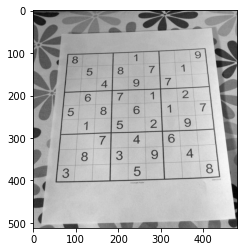

In [4]:
img1 = '../img/sudoku-800x800.png'
img2 = '../img/sudoku-481x512.jpeg'
img = load_image(img2)
plt.imshow(img, cmap='gray')

Use canny filter to detect lines. img2 shows, that this not works perfectly.

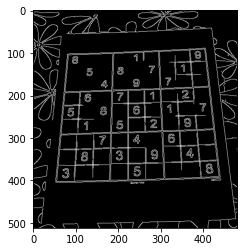

In [5]:
dst = cv2.Canny(img, 50, 200)
plt.imshow(dst, cmap='gray')

Hough transform does not solve it either.

53 lines detected


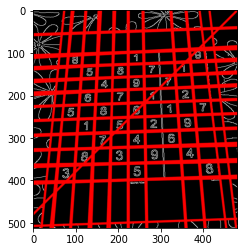

In [6]:
lines = detect_lines(img)

print(f'{len(lines)} lines detected')

cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
if lines is not None:
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (255,0,0), 3, cv2.LINE_AA)
plt.imshow(cdst)

There is also a `findContours` method, but doesn't solve the problem either.

107


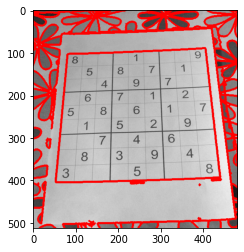

In [7]:
dst = cv2.Canny(img, 20, 100, None, 3)
contours, hierarchy= cv2.findContours(dst, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

print(len(contours))

copy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for contour in contours:
    cv2.drawContours(copy, contour, -1, (255,0,0),3)
plt.imshow(copy)

Note that above indeed 81 tiles are found in img1, but no contour that marks the whole game. Since a not perfect image would result in wrong contours (see img2 for example) this should not be considered as a solution.

Therefore we will use Hough-Transformation and add a border to detect the whole game border.

In [8]:
bordersize = 10
img = cv2.copyMakeBorder(
    img,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=[255, 255, 255]
)

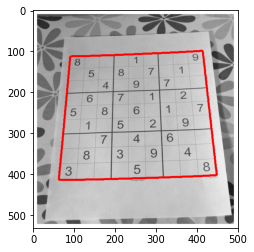

In [9]:
largest_item = find_biggest_contour(img)

copy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(copy, largest_item, -1, (255,0,0),3)
plt.imshow(copy)

Find smallest rectangle which includes the entire contour.

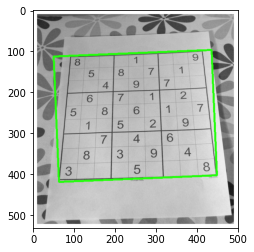

In [10]:
copy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

rect = cv2.minAreaRect(largest_item)
box = np.int0(cv2.boxPoints(rect))
cv2.drawContours(copy, [box], 0, (36,255,12), 3)

plt.imshow(copy)

Use the rectangle to find the corners of the contour using euclidean distance.

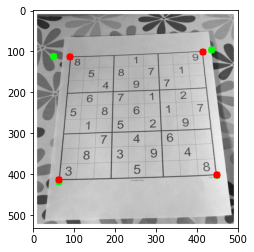

In [11]:
copy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

corners = get_corners_of_contour(largest_item)

for reference_point in box:
    cv2.circle(copy, reference_point, 1, (0, 255, 0), 15)

for corner in corners:
    cv2.circle(copy, corner[0], 1, (255, 0, 0), 15)

plt.imshow(copy)

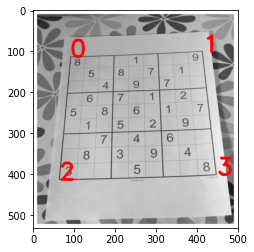

In [12]:
copy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for i in range(len(corners)):
    cv2.putText(copy, str(i), corners[i][0], cv2.FONT_HERSHEY_DUPLEX, 2, (255, 0, 0), 3)

plt.imshow(copy)

Warp image using perspective transformation.

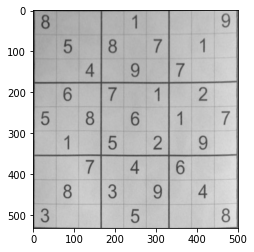

In [13]:
copy = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

warped = perspective_transform(copy, corners.astype(np.float32))
    
plt.imshow(warped)

Use Hough Transform again to find rows and columns.

20 lines detected


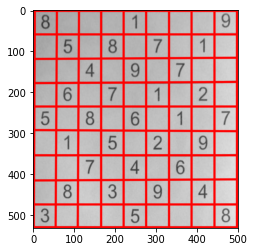

In [14]:
lines = detect_lines(warped)

# Merge close lines
lines = merge_lines(lines, rho_threshold=20, theta_threshold=0.5)

print(f'{len(lines)} lines detected')

copy = np.copy(warped)
if lines is not None:
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(copy, pt1, pt2, (255,0,0), 3, cv2.LINE_AA)
plt.imshow(copy)

Split image into tiles.

In [15]:
rows = []
cols = []
threshold1 = math.radians(45)
threshold2 = math.radians(135)
threshold3 = math.radians(225)
threshold4 = math.radians(315)
for line in lines:
    if line[0][1] > threshold4:
        cols.append(line[0][0])
    elif line[0][1] > threshold3:
        rows.append(-line)
    elif line[0][1] > threshold2:
        cols.append(-line[0][0])
    elif line[0][1] > threshold1:
        rows.append(line[0][0])
    else:
        cols.append(line[0][0])

cols = np.stack(cols, axis=0)
rows = np.stack(rows, axis=0)

# Sort ascending
cols = np.sort(cols)
rows = np.sort(rows)

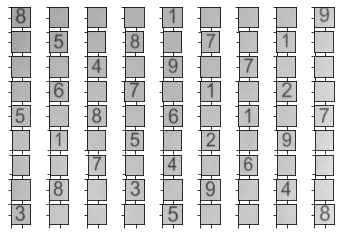

In [16]:
padding = len(warped) // 100
tiles = split_image_into_tiles(lines, padding=padding)
    
fig, axs = plt.subplots(9, 9, sharex='col', sharey='row')

n = 0
for i in range(9):
    for j in range(9):
        axs[i][j].imshow(warped[tiles[n]['row_start']:tiles[n]['row_end'], tiles[n]['col_start']:tiles[n]['col_end']])
        axs[i][j].set_yticklabels([])
        axs[i][j].set_xticklabels([])
        n += 1

Convert warped image to binary image to improve OCR.

Perform OCR to recognize numbers.

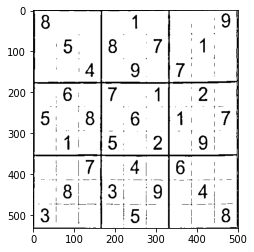

In [27]:
pytesseract.pytesseract.tesseract_cmd = r'E:\Program Files\Tesseract-OCR\tesseract.exe'

binary = convert_to_binary_image(warped)
binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
plt.imshow(binary)

cells = find_numbers_in_tiled_image(binary, tiles)

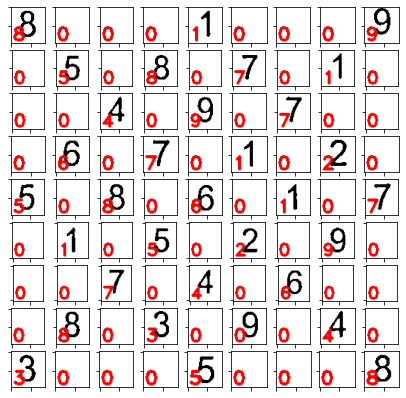

In [28]:
fig, axs = plt.subplots(9, 9, figsize=(7,7), sharex='col', sharey='row')

n = 0
for i in range(9):
    for j in range(9):
        image = np.copy(thr[tiles[n]['row_start']:tiles[n]['row_end'], tiles[n]['col_start']:tiles[n]['col_end']])
        cv2.putText(image,
                    str(cells[n]),
                    (2, len(image) - 4),
                    cv2.FONT_HERSHEY_DUPLEX,
                    0.8,
                    (255, 0, 0),
                    2)
        axs[i][j].imshow(image)
        axs[i][j].set_yticklabels([])
        axs[i][j].set_xticklabels([])
        n += 1